## Загрузка библиотек и данных

In [9]:
!pip install catboost -q

In [96]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import Pool
from sklearn.model_selection import GridSearchCV


#import shap

random.seed(42)
np.random.seed(42)

In [137]:
df_train   = pd.read_csv('train_initial_with_pois.csv')

In [138]:
df_train_new = pd.read_csv('train_atm.csv')

Работа с банкоматами

In [139]:
df_train['atm_group'].value_counts()

5478.0    2662
1942.0    1160
8083.0    1050
496.5      616
3185.5     594
1022.0     136
32.0        43
Name: atm_group, dtype: int64

In [140]:
df_train['atm_group'] = df_train['atm_group'].replace({8083.0: 'Росбанк',
                                                       1022.0: 'АК Барс',
                                                       1942.0: 'Альфабанк',
                                                       3185.5: 'Газпромбанк',
                                                       32.0: 'Райффазен',
                                                       496.5: 'Россельхозбанк',
                                                       5478.0: 'Уралсиб'})

In [141]:
df_train_new['atm_group'] = df_train_new['atm_group'].replace({8083.0: 'Росбанк',
                                                       1022.0: 'АК Барс',
                                                       1942.0: 'Альфабанк',
                                                       3185.5: 'Газпромбанк',
                                                       32.0: 'Райффазен',
                                                       496.5: 'Россельхозбанк',
                                                       5478.0: 'Уралсиб'})

## Работа с пропусками

In [143]:
df_train_new.isna().sum()

id_0                          0
id                            0
atm_group                     0
address                       0
address_rus                   0
lat                           1
long                          1
target                        0
federal_district             43
region_with_type             43
area_with_type             5416
city_with_type              489
city_area                  5647
city_district_with_type    4336
capital_marker               43
settlement_with_type       5737
street_with_type            193
house                       588
nearest_metro_distance     5038
metro_station_name_1       5131
metro_line_name_1          5131
metro_distance_1           5131
metro_station_name_2       5147
metro_line_name_2          5147
metro_distance_2           5147
metro_station_name_3       5168
metro_line_name_3          5168
metro_distance_3           5168
locality_area                89
locality_population          89
dtype: int64

In [144]:
# Замена nan на '' - чтобы слить в поле city
df_train_new['city_with_type'].fillna('', inplace=True)
df_train_new['city_area'].fillna('', inplace=True)
df_train_new['settlement_with_type'].fillna('', inplace=True)
df_train_new['city_district_with_type'].fillna('', inplace=True)

## Объединение таблиц

In [145]:
merged_df = df_train_new.merge(df_train, left_on='id', right_on='id', how='left')

In [146]:
df_train_new.shape

(6261, 30)

In [147]:
df_train.shape

(6261, 50)

In [148]:
merged_df.shape

(6261, 79)

In [149]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6261 entries, 0 to 6260
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id_0                            6261 non-null   int64  
 1   id                              6261 non-null   float64
 2   atm_group_x                     6261 non-null   object 
 3   address_x                       6261 non-null   object 
 4   address_rus_x                   6261 non-null   object 
 5   lat_x                           6260 non-null   float64
 6   long_x                          6260 non-null   float64
 7   target_x                        6261 non-null   float64
 8   federal_district                6218 non-null   object 
 9   region_with_type                6218 non-null   object 
 10  area_with_type                  845 non-null    object 
 11  city_with_type                  6261 non-null   object 
 12  city_area                       62

In [150]:
#Убираем лишние столбцы
merged_df.drop(['lat_y', 'long_y','address_rus_y', 'target_y','Unnamed: 0',
                'atm_group_y', 'address_x', 'address_y', 'address_rus_x', 'address_rus_y','id_0','id'], axis=1, inplace=True)

In [151]:
#Оставляем непустые строки
cols = ['education', 'fuel', 'car_service', 'parking_space', 'atm', 'bank', 'bureau_de_change',
        'outpatient_medical_facilities', 'inplace_medical_facilities', 'pharmacy', 'veterinary', 'entertainment',
        'entertainment_for_adults', 'administrative_buildings', 'police', 'fire_station', 'post_office', 'grave_yard',
        'marketplace', 'monastery', 'place_of_worship', 'public_transport_stop_position']

merged_df = merged_df[merged_df[cols].notnull().all(axis=1)]

In [152]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5955 entries, 0 to 6260
Data columns (total 68 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   atm_group_x                     5955 non-null   object 
 1   lat_x                           5955 non-null   float64
 2   long_x                          5955 non-null   float64
 3   target_x                        5955 non-null   float64
 4   federal_district                5912 non-null   object 
 5   region_with_type                5912 non-null   object 
 6   area_with_type                  821 non-null    object 
 7   city_with_type                  5955 non-null   object 
 8   city_area                       5955 non-null   object 
 9   city_district_with_type         5955 non-null   object 
 10  capital_marker                  5912 non-null   float64
 11  settlement_with_type            5955 non-null   object 
 12  street_with_type                57

In [153]:
merged_df.head()

,atm_group_x,lat_x,long_x,target_x,federal_district,region_with_type,area_with_type,city_with_type,city_area,city_district_with_type,...,interior_store,electronics_store,sport_store,auto_moto_store,car_parts_store,hobbies_store,books_store,other_type_store,hotel,museum
0,Россельхозбанк,46.318213,44.260407,0.019958,Южный,Респ Калмыкия,NaN,г Элиста,,,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Россельхозбанк,48.520503,135.052576,-0.048769,Дальневосточный,Хабаровский край,NaN,г Хабаровск,,Кировский р-н,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,Россельхозбанк,62.025583,129.721362,-0.041545,Дальневосточный,Респ Саха /Якутия/,NaN,г Якутск,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,Россельхозбанк,50.089050,118.027310,0.025479,Дальневосточный,Забайкальский край,Краснокаменский р-н,г Краснокаменск,,,...,0.0,6.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
5,Россельхозбанк,57.769435,40.930802,-0.089909,Центральный,Костромская обл,NaN,г Кострома,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [154]:
merged_df.shape

(5955, 68)

In [155]:
merged_df.isna().sum().sum()

54551

In [156]:
print(f'Удалено {6261-5749} строк')

Удалено 512 строк


In [157]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5955 entries, 0 to 6260
Data columns (total 68 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   atm_group_x                     5955 non-null   object 
 1   lat_x                           5955 non-null   float64
 2   long_x                          5955 non-null   float64
 3   target_x                        5955 non-null   float64
 4   federal_district                5912 non-null   object 
 5   region_with_type                5912 non-null   object 
 6   area_with_type                  821 non-null    object 
 7   city_with_type                  5955 non-null   object 
 8   city_area                       5955 non-null   object 
 9   city_district_with_type         5955 non-null   object 
 10  capital_marker                  5912 non-null   float64
 11  settlement_with_type            5955 non-null   object 
 12  street_with_type                57

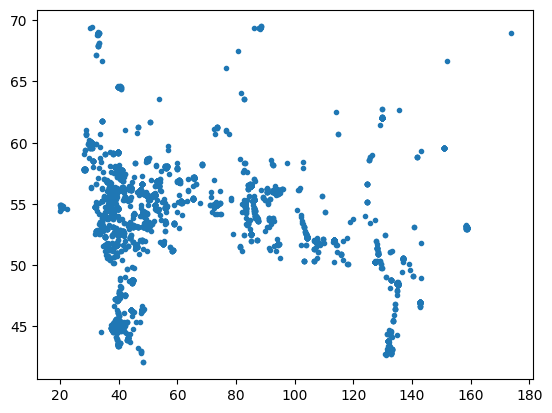

In [158]:
#Координаты банкоматов
plt.figure
plt.plot(merged_df['long_x'], merged_df['lat_x'], '.')

## Вынесенные методы

In [33]:
def one_hot_encode_drop_first(X_train, X_test, cols):
    drop_enc = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train[cols])

    X_train_enc = pd.DataFrame(drop_enc.transform(X_train[cols]).toarray(),
                               columns=drop_enc.get_feature_names_out(cols),
                               dtype=int)
    X_test_enc = pd.DataFrame(drop_enc.transform(X_test[cols]).toarray(),
                              columns=drop_enc.get_feature_names_out(cols),
                              dtype=int)

    X_train_enc = X_train_enc.reset_index(drop=True)
    X_test_enc = X_test_enc.reset_index(drop=True)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    X_train_enc = pd.concat([X_train.drop(columns=cols), X_train_enc], axis=1)
    X_test_enc = pd.concat([X_test.drop(columns=cols), X_test_enc], axis=1)

    return X_train_enc, X_test_enc


In [54]:
def regression(model, X_train, X_test, y_train, y_test, features):
    # Создаем модель линейной регрессии
    #model = Lasso()

    # Обучаем модель на тренировочных данных
    model.fit(X_train, y_train)

    # Предсказываем значения для тренировочного и тестового набора данных
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
    mse_train = MSE(y_train, pred_train)
    mse_test = MSE(y_test, pred_test)

     # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))


    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)



    print(f'MSE для трейна равно {mse_train:.4f}')
    print(f'MSE для теста равно {mse_test:.4f}')

    print(f'RMSE для трейна равно {rmse_train:.4f}')
    print(f'RMSE для теста равно {rmse_test:.4f}')

    print(f'r2 для трейна равно {r2_train:.10f}')
    print(f'r2 для теста равно {r2_test:.10f}')

    weights = abs(model.coef_)

    return mse_train, mse_test, r2_train, r2_test, weights

In [37]:
def get_weights(features, weights):
  feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
  feature_weights.sort_values(by='Weight', ascending=False)
  return feature_weights

In [38]:
  def scale_data(X_train, X_test):
    X_train_sc = X_train_enc.copy()
    X_test_sc = X_test_enc.copy()
    scaler = StandardScaler()
    scaler.fit(X_train_enc)
    X_train_sc = scaler.transform(X_train_enc)
    X_test_sc = scaler.transform(X_test_enc)
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_enc.columns)
    return  X_train_sc, X_test_sc

In [39]:
  def scale_data_cols(X_train, X_test, cols):
    X_train_sc = X_train_enc.copy()
    X_test_sc = X_test_enc.copy()
    scaler = StandardScaler()
    scaler.fit(X_train_enc[cols])
    X_train_sc[cols] = scaler.transform(X_train_enc[cols])
    X_test_sc[cols] = scaler.transform(X_test_enc[cols])
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_enc.columns)
    return  X_train_sc, X_test_sc

In [159]:
def grid_search(model,params,cv,scoring,X_train,X_test, y_train, y_test):

  # первый параметр - модель, второй - словарь параметров, третий - число фолдов, четвертый - метрика
  gs = GridSearchCV(model, params, cv=cv, scoring=scoring)

  gs.fit(X_train, y_train) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)

  print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
  print(gs.best_params_) # оптимальные гиперпараметры

  pred_train = gs.predict(X_train)
  pred_test = gs.predict(X_test)


  # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
  mse_train = MSE(y_train, pred_train)
  mse_test = MSE(y_test, pred_test)
  # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)


  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')


  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  weights = abs(gs.best_estimator_.coef_)

  return mse_train, mse_test, r2_train, r2_test, weights


In [43]:
def cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices):

  # Создаем модель CatBoostRegressor
  model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)

  model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Verbose',
  #    plot=True
  )

  # Предсказываем значения для тренировочного и тестового набора данных
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  # Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

  rmse_train = np.sqrt(mse_train)
  rmse_test = np.sqrt(mse_test)

  # Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE и r2 для тренировочного и тестового набора данных
  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

# Выводим значения MSE и r2 для тренировочного и тестового набора данных
  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test

In [44]:
def grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test):

# Задаем сетку параметров для перебора

# Создаем модель CatBoostRegressor
  model = CatBoostRegressor(iterations=2, loss_function=loss)

# Создаем объект GridSearchCV для перебора параметров
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)

# Обучаем модель с использованием поиска по сетке
  grid_search.fit(X_train, y_train, cat_features=categorical_features_indices)

# Получаем лучшие параметры из поиска
  best_params = grid_search.best_params_

# Создаем модель с лучшими параметрами
  model = CatBoostRegressor(**best_params)

# Обучаем модель на тренировочных данных
  model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Предсказываем значения для тренировочного и тестового набора данных
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mse_train)
  rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  #weights = abs(grid_search.best_estimator_.coef_)

  return mse_train, mse_test, r2_train, r2_test

In [45]:
def pool_cat_boost(X_train, X_test):

  # Создаем модель CatBoostRegressor
  params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}

  model = CatBoostRegressor(**params)
  model.fit(X_train, y_train, categorical_features_indices)
  cv_dataset = Pool(data=X_train,
                  label=y_train,
                   cat_features=categorical_features_indices)
  scores = cv(cv_dataset,
            params,
            fold_count=5,
            plot="True")

  # Предсказываем значения для тренировочного и тестового набора данных
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  # Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

  # Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  # Выводим значения MSE и r2 для тренировочного и тестового набора данных
  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test

## Линейные модели без категориального признака city

In [46]:
df = merged_df.copy()

In [47]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [48]:
#Удалени улицы
df.drop('street_with_type', axis=1, inplace=True)

In [49]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
#df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

In [50]:
df.columns

Index(['atm_group_x', 'lat_x', 'long_x', 'target_x', 'federal_district',
       'region_with_type', 'capital_marker', 'locality_area',
       'locality_population', 'sustenance', 'education', 'fuel', 'car_service',
       'parking_space', 'atm', 'bank', 'bureau_de_change',
       'outpatient_medical_facilities', 'inplace_medical_facilities',
       'pharmacy', 'veterinary', 'entertainment', 'entertainment_for_adults',
       'administrative_buildings', 'police', 'fire_station', 'post_office',
       'grave_yard', 'marketplace', 'monastery', 'place_of_worship',
       'public_transport_stop_position', 'alcohol_shop', 'food_shop',
       'supermarket', 'mall', 'wholesale', 'clothing_shop', 'discount_store',
       'beauty_store', 'hardware_store', 'interior_store', 'electronics_store',
       'sport_store', 'auto_moto_store', 'car_parts_store', 'hobbies_store',
       'books_store', 'other_type_store', 'hotel', 'museum'],
      dtype='object')

In [51]:
Y = df['target_x']
X = df.drop(columns=["target_x"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Без масштабирования - Линейная регрессия

In [52]:
cols = ['atm_group_x','federal_district', 'region_with_type']
X_train_enc, X_test_enc = one_hot_encode_drop_first(X_train, X_test, cols)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [55]:
a,b,c,d, weights = regression(LinearRegression(),X_train_enc, X_test_enc, y_train, y_test, X_train_enc.columns)

MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0445
RMSE для теста равно 0.0470
r2 для трейна равно 0.7350376731
r2 для теста равно 0.6957650402


In [ ]:
get_weights(X_train_enc.columns,weights)

,Feature,Weight
0,lat_x,3.157700e-03
1,long_x,8.256681e-04
2,capital_marker,2.608645e-03
3,locality_area,1.855537e-08
4,locality_population,1.168727e-10
...,...,...
133,region_with_type_Чувашская Республика - Чувашия,1.073394e-02
134,region_with_type_Чувашская республика - Чувашия,1.677012e-02
135,region_with_type_Ярославская обл,3.024047e-02
136,region_with_type_г Москва,1.522305e-02


In [ ]:
#X_train['other_type_store'].value_counts()
#X_train.columns

С маштабированием - линейная регрессия

In [56]:
cols = ['locality_area','locality_population','lat_x', 'long_x','sustenance','education','fuel',
        'car_service','parking_space','atm','bank','bureau_de_change','outpatient_medical_facilities',
        'pharmacy','veterinary','entertainment','entertainment_for_adults',
        'administrative_buildings', 'police', 'fire_station', 'post_office',
       'grave_yard', 'marketplace', 'monastery', 'place_of_worship',
         'public_transport_stop_position', 'alcohol_shop', 'food_shop',
       'supermarket', 'mall', 'wholesale', 'clothing_shop', 'discount_store',
        'beauty_store', 'hardware_store', 'interior_store', 'electronics_store',
       'sport_store', 'auto_moto_store', 'car_parts_store', 'hobbies_store',
        'books_store', 'hotel', 'museum','other_type_store']
X_train_sc, X_test_sc = scale_data(X_train_enc, X_test_enc)

In [57]:
a,b,c,d, weights = regression(LinearRegression(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0020
MSE для теста равно 684498593511718912.0000
RMSE для трейна равно 0.0445
RMSE для теста равно 827344301.6736
r2 для трейна равно 0.7350388581
r2 для теста равно -94108729061056528384.0000000000


In [ ]:
get_weights(X_train_sc.columns,weights)

,Feature,Weight
0,lat_x,1.346644e-02
1,long_x,2.704257e-02
2,capital_marker,2.419002e-03
3,locality_area,2.037086e-03
4,locality_population,4.328550e-04
...,...,...
133,region_with_type_Чувашская Республика - Чувашия,1.315759e+09
134,region_with_type_Чувашская республика - Чувашия,7.860842e+09
135,region_with_type_Ярославская обл,5.857357e+09
136,region_with_type_г Москва,1.519824e+10


In [ ]:
#X_train_sc['region_with_type_Хабаровский край'].value_counts()

In [ ]:
X_train_sc.head()

,lat_x,long_x,capital_marker,locality_area,locality_population,sustenance,education,fuel,car_service,parking_space,...,region_with_type_Ульяновская обл,region_with_type_Хабаровский край,region_with_type_Ханты-Мансийский Автономный округ - Югра,region_with_type_Ханты-Мансийский Автономный округ - Югра АО,region_with_type_Челябинская обл,region_with_type_Чувашская Республика - Чувашия,region_with_type_Чувашская республика - Чувашия,region_with_type_Ярославская обл,region_with_type_г Москва,region_with_type_г Санкт-Петербург
0,0.205712,0.588449,2.0,-0.080855,-0.061381,1.226688,0.181374,-0.210682,-0.25713,-0.022852,...,0,0,0,0,0,0,0,0,0,0
1,0.398643,-0.792769,0.0,-0.061919,3.037401,1.000683,0.181374,-0.210682,-0.25713,-0.022852,...,0,0,0,0,0,0,0,0,1,0
2,1.168982,-0.784576,0.0,-0.083999,-0.428890,-0.355347,1.106944,-0.210682,-0.25713,-0.022852,...,0,0,0,0,0,0,0,0,0,0
3,-0.019731,-0.773742,1.0,-0.084273,-0.482869,-0.581352,-0.744196,-0.210682,-0.25713,-0.022852,...,0,0,0,0,0,0,0,0,0,0
4,0.191453,0.300999,2.0,-0.085230,-0.193470,-0.581352,-0.744196,-0.210682,-0.25713,-0.022852,...,0,0,0,0,0,0,0,0,0,0


Lasso

In [58]:
a,b,c,d, weights = regression(Lasso(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


Lasso - подбор оптимальных гиперпараметров

In [61]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d, weights = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

0.7129277069538885
{'alpha': 0.0001}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0446
RMSE для теста равно 0.0470
r2 для трейна равно 0.7340406780
r2 для теста равно 0.6961212475


In [ ]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'neg_mean_squared_error'
a,b,c,d, weights = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

-0.0021422973310391722
{'alpha': 0.0001}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
r2 для трейна равно 0.7340406780
r2 для теста равно 0.6961212475


Ridge

In [62]:
a,b,c,d, weights = regression(Ridge(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0445
RMSE для теста равно 0.0470
r2 для трейна равно 0.7350219415
r2 для теста равно 0.6958107517


Подбор параметров Ridge

In [63]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 10, 100)}
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(Ridge(),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

0.7122245316755335
{'alpha': 3.6}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0445
RMSE для теста равно 0.0470
r2 для трейна равно 0.7349621078
r2 для теста равно 0.6958911858


Elastic_net

In [64]:
a,b,c,d, weights = regression(ElasticNet(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


Подбор Elastic_net

In [65]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.001, 1, 100),
'l1_ratio': np.linspace(0.01, 1, 10)}
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(ElasticNet(max_iter=5000),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

#a,b,c,d, weights = elastic_net(params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

0.7133423392830495
{'alpha': 0.001, 'l1_ratio': 0.34}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0449
RMSE для теста равно 0.0471
r2 для трейна равно 0.7305915883
r2 для теста равно 0.6945017855


In [ ]:
get_weights(X_train_sc.columns,weights)

,Feature,Weight
0,lat_x,0.000000
1,long_x,0.006344
2,capital_marker,0.001068
3,locality_area,0.001562
4,locality_population,0.000000
...,...,...
133,region_with_type_Чувашская Республика - Чувашия,0.000000
134,region_with_type_Чувашская республика - Чувашия,0.001008
135,region_with_type_Ярославская обл,0.001335
136,region_with_type_г Москва,0.006203


Полиномиальные признаки

In [66]:
# Фильтруем поля, не имеющие тип object
non_object_fields = X_train_enc.select_dtypes(exclude='object').columns
X_train_filtered = X_train_enc[non_object_fields]

X_train_filtered.head()

,lat_x,long_x,capital_marker,locality_area,locality_population,sustenance,education,fuel,car_service,parking_space,...,region_with_type_Ульяновская обл,region_with_type_Хабаровский край,region_with_type_Ханты-Мансийский Автономный округ - Югра,region_with_type_Ханты-Мансийский Автономный округ - Югра АО,region_with_type_Челябинская обл,region_with_type_Чувашская Республика - Чувашия,region_with_type_Чувашская республика - Чувашия,region_with_type_Ярославская обл,region_with_type_г Москва,region_with_type_г Санкт-Петербург
0,54.984114,82.891603,2.0,480.886137,1625631.0,8.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.806894,37.635593,0.0,2562.617022,12678079.0,7.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,59.092104,37.904045,0.0,135.301998,314834.0,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,54.022683,38.259044,1.0,105.148100,122306.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,54.923305,73.473216,2.0,0.000000,1154507.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train_sc[non_object_fields])


Добавление полиномиальных признаков

In [68]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train_sc)
X_test_poly = poly.fit_transform(X_test_sc)

In [69]:
a,b,c,d, weights = regression(LinearRegression(),X_train_poly, X_test_poly, y_train, y_test, X_train_enc.columns)

MSE для трейна равно 0.0002
MSE для теста равно 156942379161556384.0000
RMSE для трейна равно 0.0130
RMSE для теста равно 396159537.5118
r2 для трейна равно 0.9773853441
r2 для теста равно -21577323867006095360.0000000000


Lasso (полиномиальные)



In [70]:
a,b,c,d, weights = regression(Lasso(),X_train_poly, X_test_poly, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


Lasso (полиномиальные) - подбор

In [71]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d, weights = grid_search(Lasso(max_iter=1000),params,cv,scoring,X_train_poly,X_test_poly, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.280e-01, tolerance: 2.424e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-01, tolerance: 2.478e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.627e-01, tolerance: 2.483e

0.6841390130806186
{'alpha': 0.010199999999999999}
MSE для трейна равно 0.0023
MSE для теста равно 0.0024
RMSE для трейна равно 0.0478
RMSE для теста равно 0.0494
r2 для трейна равно 0.6946126815
r2 для теста равно 0.6649955422


Ridge (полиномиальные)

In [72]:
a,b,c,d, weights = regression(Ridge(),X_train_poly, X_test_poly, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0003
MSE для теста равно 0.0452
RMSE для трейна равно 0.0170
RMSE для теста равно 0.2126
r2 для трейна равно 0.9612191531
r2 для теста равно -5.2119788551


Ridge на сетке (долго считает)

In [79]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 100, 10)}
params = {'alpha' : np.linspace(0.1, 5000, 20)} # 9 vby
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(Ridge(),params,cv,scoring,X_train_poly, X_test_poly, y_train, y_test)

0.6447068675931142
{'alpha': 2631.6263157894737}
MSE для трейна равно 0.0011
MSE для теста равно 0.0026
RMSE для трейна равно 0.0337
RMSE для теста равно 0.0512
r2 для трейна равно 0.8481817808
r2 для теста равно 0.6393099100


Elastic_net

In [80]:
a,b,c,d, weights = regression(ElasticNet(),X_train_poly, X_test_poly, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


In [84]:
params = {'alpha' : np.linspace(0.001, 1, 10),
'l1_ratio': np.linspace(0.01, 1, 10)}

params = {'alpha' : np.linspace(0.001, 1, 10), 'l1_ratio': np.linspace(0.01, 1, 10)} #26 мин
cv = 5
scoring="r2"

grid_search(ElasticNet(),params,cv,scoring,X_train_poly,X_test_poly, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.702e-01, tolerance: 2.424e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e-01, tolerance: 2.478e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.344e-01, tolerance: 2.483e

0.7051744412962077
{'alpha': 0.112, 'l1_ratio': 0.01}
MSE для трейна равно 0.0017
MSE для теста равно 0.0021
RMSE для трейна равно 0.0413
RMSE для теста равно 0.0460
r2 для трейна равно 0.7717633116
r2 для теста равно 0.7085335160


(0.00170836332387802,
 0.00211997760824385,
 0.7717633115949686,
 0.7085335160059588,
 array([0.        , 0.        , 0.        , ..., 0.00145687, 0.        ,
        0.00011295]))

## Линейные модели с признаком city = city_with_type+city_area+settlement_with_type

### Обработка данных

In [227]:
df = merged_df.copy()

In [228]:
# Создание поля city - вариант 1 без района города
df['city'] = df['city_with_type'] + ' ' + df['city_area'] + ' ' + df['settlement_with_type']
df['city'] = df['city'].str.replace('  ', ' ').str.strip()

In [229]:
#df['city'].value_counts()

In [230]:
# Видно, что area_with_type не имеет смысла
#df_train_new[['city','area_with_type']].head()

In [231]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [232]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

In [233]:
#df[df['house'].isnull()]

In [234]:
#df[df['area_with_type'].isnull()]

In [235]:
#df[df['street_with_type'].isnull()]

In [236]:
#df[df['area_with_type'].notnull()]

In [237]:
#Удалени улицы
df.drop('street_with_type', axis=1, inplace=True)

In [238]:
Y = df['target_x']
X = df.drop(columns=["target_x"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Без масштабирования

In [166]:
cols = ['atm_group_x','federal_district', 'region_with_type', 'city']
X_train_enc, X_test_enc = one_hot_encode_drop_first(X_train, X_test, cols)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [167]:
a,b,c,d, weights = regression(LinearRegression(),X_train_enc, X_test_enc, y_train, y_test, X_train_enc.columns)

MSE для трейна равно 0.0015
MSE для теста равно 16589270.2270
RMSE для трейна равно 0.0393
RMSE для теста равно 4072.9928
r2 для трейна равно 0.7946910381
r2 для теста равно -2289881827.7173027992


### Масштабирование

In [239]:
X_train_sc, X_test_sc = scale_data(X_train_enc, X_test_enc)



### LinearRegression

In [169]:
a,b,c,d, weights = regression(LinearRegression(), X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0017
MSE для теста равно 698354992172247084433408.0000
RMSE для трейна равно 0.0418
RMSE для теста равно 835676368082.9122
r2 для трейна равно 0.7674380013
r2 для теста равно -96396669936877824112590848.0000000000


### Lasso

In [170]:
a,b,c,d, weights = regression(Lasso(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0072
RMSE для трейна равно 0.0866
RMSE для теста равно 0.0851
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000670789


### Lasso - подбор по сетке

In [240]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d, weights = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

0.679586483812735
{'alpha': 0.0001}
MSE для трейна равно 0.0008
MSE для теста равно 0.0027
RMSE для трейна равно 0.0276
RMSE для теста равно 0.0516
r2 для трейна равно 0.8986748328
r2 для теста равно 0.6329714011


### Ridge

In [173]:
a,b,c,d, weights = regression(Ridge(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0015
MSE для теста равно 0.0024
RMSE для трейна равно 0.0393
RMSE для теста равно 0.0494
r2 для трейна равно 0.7942624933
r2 для теста равно 0.6634410654


### Ridge подбор по сетке

In [175]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 50, 100)}
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(Ridge(),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

0.710286161569778
{'alpha': 35.88686868686869}
MSE для трейна равно 0.0016
MSE для теста равно 0.0023
RMSE для трейна равно 0.0395
RMSE для теста равно 0.0482
r2 для трейна равно 0.7923291521
r2 для теста равно 0.6793210903


### Elastic_net

In [178]:
a,b,c,d, weights = regression(ElasticNet(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0072
RMSE для трейна равно 0.0866
RMSE для теста равно 0.0851
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000670789


### ElastciNet подбор по сетке

In [179]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 10, 100),
'l1_ratio': np.linspace(0.1, 1, 10)}
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(ElasticNet(),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

0.6089961944366145
{'alpha': 0.1, 'l1_ratio': 0.1}
MSE для трейна равно 0.0029
MSE для теста равно 0.0030
RMSE для трейна равно 0.0540
RMSE для теста равно 0.0545
r2 для трейна равно 0.6114555336
r2 для теста равно 0.5901851520


### Добавление полиномиальных признаков

In [180]:
cols = ['locality_area','locality_population','lat_x', 'long_x','sustenance','education','fuel',
        'car_service','parking_space','atm','bank','bureau_de_change','outpatient_medical_facilities',
        'pharmacy','veterinary','entertainment','entertainment_for_adults',
        'administrative_buildings', 'police', 'fire_station', 'post_office',
       'grave_yard', 'marketplace', 'monastery', 'place_of_worship',
         'public_transport_stop_position', 'alcohol_shop', 'food_shop',
       'supermarket', 'mall', 'wholesale', 'clothing_shop', 'discount_store',
        'beauty_store', 'hardware_store', 'interior_store', 'electronics_store',
       'sport_store', 'auto_moto_store', 'car_parts_store', 'hobbies_store',
        'books_store', 'hotel', 'museum','other_type_store']
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
#X_train_poly = X_train_sc.copy()
#X_test_poly = X_test_sc.copy()
X_train_poly = pd.DataFrame(poly.fit_transform(X_train_sc[cols]))
X_test_poly = pd.DataFrame(poly.fit_transform(X_test_sc[cols]))
X_train_poly.columns = X_train_poly.columns.astype(str)
X_test_poly.columns = X_test_poly.columns.astype(str)

In [ ]:
X_train_poly.shape

(4024, 1081)

In [181]:
X_train_poly_new = pd.concat([X_train_sc.drop(columns=cols), X_train_poly], axis=1)
X_test_poly_new = pd.concat([X_test_sc.drop(columns=cols), X_test_poly], axis=1)

In [ ]:
X_train_poly_new.shape

(4024, 1819)

In [ ]:
X_train_poly_new.columns

Index(['capital_marker', 'inplace_medical_facilities', 'atm_group_x_Альфабанк',
       'atm_group_x_Газпромбанк', 'atm_group_x_Райффазен',
       'atm_group_x_Росбанк', 'atm_group_x_Россельхозбанк',
       'atm_group_x_Уралсиб', 'federal_district_Приволжский',
       'federal_district_Северо-Западный',
       ...
       '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079',
       '1080'],
      dtype='object', length=1819)

### Линейная регрессия на полиномиальных признаках

In [182]:
a,b,c,d, weights = regression(LinearRegression(), X_train_poly_new, X_test_poly_new, y_train, y_test, X_train_poly_new.columns)

MSE для трейна равно 0.0010
MSE для теста равно 1270558824322326784.0000
RMSE для трейна равно 0.0322
RMSE для теста равно 1127190677.8901
r2 для трейна равно 0.8619735913
r2 для теста равно -175380202041110528000.0000000000


### Lasso на полиномиальных признаках

In [183]:
a,b,c,d, weights = regression(Lasso(),X_train_poly_new, X_test_poly_new, y_train, y_test, X_train_poly_new.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0072
RMSE для трейна равно 0.0866
RMSE для теста равно 0.0851
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000670789


### Lasso на сетке на полиномиальных признаках

In [184]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d, weights = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

0.715740928546871
{'alpha': 0.0001}
MSE для трейна равно 0.0016
MSE для теста равно 0.0023
RMSE для трейна равно 0.0395
RMSE для теста равно 0.0477
r2 для трейна равно 0.7916341319
r2 для теста равно 0.6863703802


### Ridge на полиномиальных признаках

In [185]:
a,b,c,d, weights = regression(Ridge(),X_train_poly_new, X_test_poly_new, y_train, y_test, X_train_poly_new.columns)

MSE для трейна равно 0.0011
MSE для теста равно 0.0162
RMSE для трейна равно 0.0325
RMSE для теста равно 0.1271
r2 для трейна равно 0.8594036290
r2 для теста равно -1.2298151426


### Ridge (подбор по сетке) на полиномиальных признаках

In [ ]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 50, 100)}
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(Ridge(),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

In [187]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 700, 100)}
cv = 5
scoring="neg_mean_squared_error"

a,b,c,d, weights = grid_search(Ridge(),params,cv,scoring,X_train_poly_new, X_test_poly_new, y_train, y_test)

-0.0024898907397365084
{'alpha': 629.3030303030303}
MSE для трейна равно 0.0013
MSE для теста равно 0.0035
RMSE для трейна равно 0.0362
RMSE для теста равно 0.0591
r2 для трейна равно 0.8251990257
r2 для теста равно 0.5179822174


### Elastic_Net на полиномиальных признаках

In [188]:
a,b,c,d, weights = regression(ElasticNet(),X_train_poly_new, X_test_poly_new, y_train, y_test,X_train_poly_new.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0072
RMSE для трейна равно 0.0866
RMSE для теста равно 0.0851
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000670789


### Elastic_Net (по сетке) на полиномиальных признаках

In [190]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 10, 100),
'l1_ratio': np.linspace(0.1, 1, 10)}
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(ElasticNet(),params,cv,scoring,X_train_poly_new, X_test_poly_new, y_train, y_test)

0.6211446010809635
{'alpha': 0.1, 'l1_ratio': 0.1}
MSE для трейна равно 0.0028
MSE для теста равно 0.0029
RMSE для трейна равно 0.0531
RMSE для теста равно 0.0540
r2 для трейна равно 0.6247252118
r2 для теста равно 0.5981975940


## Линейные модели (city = city_with_type+city_area+settlement_with_type+city_district_with_type) - неудачный вариант


In [ ]:
df = merged_df.copy()

In [ ]:
# Создание поля city - вариант 2 с районом города
df['city'] = df['city_with_type'] + ' ' + df['city_area'] + ' ' + df['settlement_with_type']+ ' ' + df['city_district_with_type']
df['city'] = df['city'].str.replace('  ', ' ').str.strip()

In [ ]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [ ]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

In [ ]:
df[df['city_district_with_type']!='']

,atm_group_x,lat_x,long_x,target_x,federal_district,region_with_type,area_with_type,city_with_type,city_area,city_district_with_type,...,electronics_store,sport_store,auto_moto_store,car_parts_store,hobbies_store,books_store,other_type_store,hotel,museum,city
2,Россельхозбанк,48.520503,135.052576,-0.048769,Дальневосточный,Хабаровский край,NaN,г Хабаровск,,Кировский р-н,...,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,г Хабаровск Кировский р-н
15,Россельхозбанк,55.751812,37.599292,-0.145001,Центральный,г Москва,NaN,г Москва,Центральный,р-н Арбат,...,2.0,0.0,0.0,0.0,0.0,6.0,8.0,6.0,0.0,г Москва Центральный р-н Арбат
16,Россельхозбанк,55.786885,49.160124,-0.101913,Приволжский,Респ Татарстан,NaN,г Казань,,Вахитовский р-н,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,г Казань Вахитовский р-н
20,Россельхозбанк,51.809602,107.646181,-0.028872,Дальневосточный,Респ Бурятия,NaN,г Улан-Удэ,,Октябрьский р-н,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,г Улан-Удэ Октябрьский р-н
21,АК Барс,55.836312,49.103566,-0.047389,Приволжский,Респ Татарстан,NaN,г Казань,,Ново-Савиновский р-н,...,0.0,0.0,0.0,2.0,0.0,0.0,10.0,0.0,0.0,г Казань Ново-Савиновский р-н
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6214,Россельхозбанк,53.239434,34.358790,-0.027334,Центральный,Брянская обл,NaN,г Брянск,,Советский р-н,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,г Брянск Советский р-н
6216,Россельхозбанк,46.351631,48.043589,-0.040804,Южный,Астраханская обл,NaN,г Астрахань,,Кировский р-н,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,г Астрахань Кировский р-н
6227,Россельхозбанк,53.268374,34.355008,-0.042957,Центральный,Брянская обл,NaN,г Брянск,,Бежицкий р-н,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,г Брянск Бежицкий р-н
6234,Россельхозбанк,48.478222,135.068800,-0.018218,Дальневосточный,Хабаровский край,NaN,г Хабаровск,,Центральный р-н,...,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,г Хабаровск Центральный р-н


In [ ]:
df['city_district_with_type'].value_counts()

                         4219
Советский р-н             142
Центральный р-н           127
Ленинский р-н             126
Октябрьский р-н            99
                         ... 
р-н Внуково                 1
Беговой р-н                 1
Савеловский р-н             1
Левобережный р-н            1
Железнодорожный округ       1
Name: city_district_with_type, Length: 153, dtype: int64

In [ ]:
df['city'].value_counts()

г Томск                                                102
г Якутск                                                90
г Новосибирск                                           73
г Воронеж                                               73
г Барнаул                                               66
                                                      ... 
пгт Подтесово                                            1
г Петрозаводск р-н Центр                                 1
г Саратов тер ОКХ Сергиевское (поселок Сергиевский)      1
пгт Карымское                                            1
г Лагань                                                 1
Name: city, Length: 1117, dtype: int64

In [ ]:
#Удалени улицы
df.drop('street_with_type', axis=1, inplace=True)

In [ ]:
Y = df['target_x']
X = df.drop(columns=["target_x"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cols = ['atm_group_x','federal_district', 'region_with_type','city']
drop_enc = OneHotEncoder(drop='first',handle_unknown='ignore').fit(X_train[cols])

X_train_enc = pd.DataFrame(drop_enc.transform(X_train[cols]).toarray(),columns=drop_enc.get_feature_names_out(cols), dtype=int)
X_test_enc = pd.DataFrame(drop_enc.transform(X_test[cols]).toarray(),columns=drop_enc.get_feature_names_out(cols), dtype=int)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_enc = X_train_enc.reset_index(drop=True)
X_test_enc = X_test_enc.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train_enc= pd.concat([X_train.drop(columns=cols), X_train_enc], axis=1)
X_test_enc = pd.concat([X_test.drop(columns=cols ), X_test_enc], axis=1)

In [ ]:
features = X_train_enc.columns

Регрессия на признаках

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

# your code here
model = LinearRegression()
model.fit(X_train_enc, y_train)

pred_train = model.predict(X_train_enc)
pred_test = model.predict(X_test_enc)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error as MSE

print(f'MSE для трейна равно {MSE(y_train, pred_train):.4f}')
print(f'MSE для теста равно {MSE(y_test, pred_test):.4f}')

print(f'r2 для трейна равно {r2_score(y_train, pred_train):.10f}')
print(f'r2 для теста равно {r2_score(y_test, pred_test):.10f}')

MSE для трейна равно 0.0014
MSE для теста равно 26550.2842
r2 для трейна равно 0.8148392664
r2 для теста равно -3664838.5339881280


Lasso регрессия

In [ ]:
from sklearn.linear_model import Lasso

# your code here
model_l1 = Lasso()
model_l1.fit(X_train_enc,y_train)
pred_train_l1 = model_l1.predict(X_train_enc)
pred_test_l1 = model_l1.predict(X_test_enc)

In [ ]:
print(f'MSE для трейна равно {MSE(y_train, pred_train_l1):.4f}')
print(f'MSE для теста равно {MSE(y_test, pred_test_l1):.4f}')

print(f'r2 для трейна равно {r2_score(y_train, pred_train_l1):.8f}')
print(f'r2 для теста равно {r2_score(y_test, pred_test_l1):.8f}')

MSE для трейна равно 0.0073
MSE для теста равно 0.0071
r2 для трейна равно 0.02486799
r2 для теста равно 0.01708784


Добавление стандартизации

In [ ]:
from sklearn.preprocessing import StandardScaler

# your code here
scaler = StandardScaler()
scaler.fit(X_train_enc)
X_train_sc = scaler.transform(X_train_enc)
X_test_sc = scaler.transform(X_test_enc)

In [ ]:
# your code here
model = LinearRegression()
model.fit(X_train_sc, y_train)

pred_train = model.predict(X_train_sc)
pred_test = model.predict(X_test_sc)

In [ ]:
print(f'MSE для трейна равно {MSE(y_train, pred_train):.4f}')
print(f'MSE для теста равно {MSE(y_test, pred_test):.4f}')

print(f'r2 для трейна равно {r2_score(y_train, pred_train):.8f}')
print(f'r2 для теста равно {r2_score(y_test, pred_test):.8f}')

MSE для трейна равно 0.0014
MSE для теста равно 96651464691790498496512.0000
r2 для трейна равно 0.81250456
r2 для теста равно -13341179550861360967450624.00000000


GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 10, 10)}

# первый параметр - модель, второй - словарь параметров, третий - число фолдов, четвертый - метрика
gs = GridSearchCV(Lasso(max_iter=1000), params, cv=5, scoring='neg_mean_squared_error')

gs.fit(X_train_enc, y_train) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'Score')

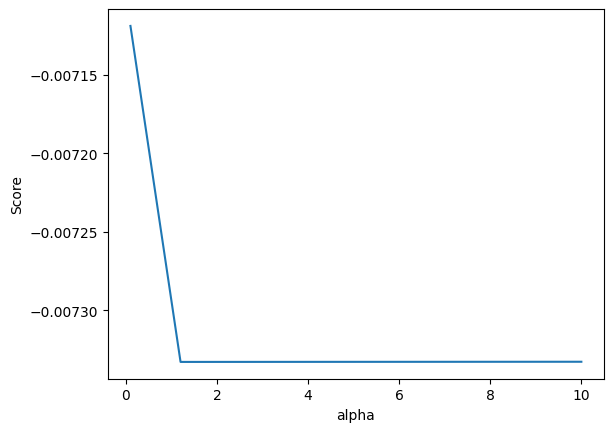

In [ ]:
plt.plot(params['alpha'], gs.cv_results_["mean_test_score"])
plt.xlabel("alpha")
plt.ylabel("Score")

In [ ]:
y_pred_train = gs.predict(X_train_enc)
y_pred_test = gs.predict(X_test_enc)

In [ ]:
print(f'MSE для трейна равно {MSE(y_train, y_pred_train):.4f}')
print(f'MSE для теста равно {MSE(y_test, y_pred_test):.4f}')

print(f'r2 для трейна равно {r2_score(y_train, y_pred_train):.8f}')
print(f'r2 для теста равно {r2_score(y_test, y_pred_test):.8f}')

MSE для трейна равно 0.0071
MSE для теста равно 0.0069
r2 для трейна равно 0.05454887
r2 для теста равно 0.04714446


## Линейная модель с признаками city, street (в процессе отладки)

In [191]:
df = merged_df.copy()

In [192]:
# Создание поля city - вариант 2 с районом города
df['city'] = df['city_with_type'] + ' ' + df['city_area'] + ' ' + df['settlement_with_type']+ ' ' + df['city_district_with_type']
df['city'] = df['city'].str.replace('  ', ' ').str.strip()

In [193]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [194]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

In [195]:
Y = df['target_x']
X = df.drop(columns=["target_x"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Кодирование категориальных признаков

In [197]:
cols = ['atm_group_x','federal_district', 'region_with_type','city','street_with_type']
X_train_enc, X_test_enc = one_hot_encode_drop_first(X_train, X_test, cols)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Масштабирование

In [198]:
X_train_sc, X_test_sc = scale_data(X_train_enc, X_test_enc)



Линейная регрессия

In [199]:
a,b,c,d, weights = regression(LinearRegression(), X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0012
MSE для теста равно 20965956194832043663687680.0000
RMSE для трейна равно 0.0343
RMSE для теста равно 4578859704646.1299
r2 для трейна равно 0.8432745392
r2 для теста равно -2894012904436684788634484736.0000000000


Lasso

In [200]:
a,b,c,d, weights = regression(Lasso(), X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0072
RMSE для трейна равно 0.0866
RMSE для теста равно 0.0851
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000670789


Lasso на сетке

In [201]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d, weights = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

0.679586483812735
{'alpha': 0.0001}
MSE для трейна равно 0.0008
MSE для теста равно 0.0027
RMSE для трейна равно 0.0276
RMSE для теста равно 0.0516
r2 для трейна равно 0.8986748328
r2 для теста равно 0.6329714011


GridSearch (масштабируемые)

## Catboost на модели без городов

### Обработка данных

In [218]:
df = merged_df.copy()

In [219]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [220]:
#Убираем ненужные столбцы
df.drop(['street_with_type'], axis =1, inplace=True)

In [221]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
#df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

### Разбиение на train/test

In [222]:
Y = df['target_x']
X = df.drop(columns=["target_x"])

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [224]:
# Определение категориальных признаков
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([0, 3, 4])

### Catboost

In [93]:
cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices)

0:	learn: 0.0531441	test: 0.0536584	best: 0.0536584 (0)	total: 50ms	remaining: 50ms
1:	learn: 0.0509162	test: 0.0509079	best: 0.0509079 (1)	total: 52.5ms	remaining: 0us

bestTest = 0.0509078984
bestIteration = 1

MSE для трейна равно 0.0025
MSE для теста равно 0.0026
RMSE для трейна равно 0.0503
RMSE для теста равно 0.0509
r2 для трейна равно 0.6624495760
r2 для теста равно 0.6436902678


(0.002526582243924285,
 0.002591614114515749,
 0.6624495759911277,
 0.6436902678170411)

### Catboost на сетке

In [ ]:
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

iter = 2
loss = 'RMSE'
cv = 5

grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)

0:	learn: 0.0842833	total: 2.09ms	remaining: 2.09ms
1:	learn: 0.0827201	total: 4.52ms	remaining: 0us
0:	learn: 0.0852307	total: 1.97ms	remaining: 1.97ms
1:	learn: 0.0836842	total: 3.5ms	remaining: 0us
0:	learn: 0.0852145	total: 1.77ms	remaining: 1.77ms
1:	learn: 0.0836728	total: 3.41ms	remaining: 0us
0:	learn: 0.0847813	total: 1.65ms	remaining: 1.65ms
1:	learn: 0.0832422	total: 3.13ms	remaining: 0us
0:	learn: 0.0849111	total: 1.67ms	remaining: 1.67ms
1:	learn: 0.0832924	total: 3.4ms	remaining: 0us
0:	learn: 0.0806175	total: 1.73ms	remaining: 1.73ms
1:	learn: 0.0759775	total: 3.2ms	remaining: 0us
0:	learn: 0.0815347	total: 1.86ms	remaining: 1.86ms
1:	learn: 0.0769479	total: 3.8ms	remaining: 0us
0:	learn: 0.0812992	total: 1.76ms	remaining: 1.76ms
1:	learn: 0.0767203	total: 3.26ms	remaining: 0us
0:	learn: 0.0811459	total: 1.67ms	remaining: 1.67ms
1:	learn: 0.0765900	total: 4.14ms	remaining: 0us
0:	learn: 0.0812338	total: 1.86ms	remaining: 1.86ms
1:	learn: 0.0764081	total: 3.66ms	remaining

(0.0007383356754828395,
 0.002041800068823363,
 0.9013586353979071,
 0.7192818052584431)

In [225]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostRegressor
def objective_catboost(trial):
    depth = trial.suggest_int("depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    iterations = trial.suggest_int("iterations", 10, 1000)

    score = cross_val_score(CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, cat_features=categorical_features_indices),
                            X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

[I 2024-01-10 17:18:21,750] A new study created in memory with name: no-name-6b1a4bc1-d6ef-4660-a863-f26a218ab8a0
[I 2024-01-10 17:18:26,915] Trial 0 finished with value: 0.7215398167696193 and parameters: {'depth': 3, 'learning_rate': 0.04588783780889915, 'iterations': 363}. Best is trial 0 with value: 0.7215398167696193.
[I 2024-01-10 17:18:31,637] Trial 1 finished with value: 0.7103065797270922 and parameters: {'depth': 5, 'learning_rate': 0.4021557060170418, 'iterations': 260}. Best is trial 0 with value: 0.7215398167696193.
[I 2024-01-10 17:18:37,095] Trial 2 finished with value: 0.034476538928536894 and parameters: {'depth': 5, 'learning_rate': 8.59966716692856e-05, 'iterations': 333}. Best is trial 0 with value: 0.7215398167696193.
[I 2024-01-10 17:18:39,323] Trial 3 finished with value: 0.03094667143954825 and parameters: {'depth': 3, 'learning_rate': 9.052299339642642e-05, 'iterations': 286}. Best is trial 0 with value: 0.7215398167696193.
[I 2024-01-10 17:18:39,657] Trial 4 f

In [98]:
study.best_params

{'depth': 5, 'learning_rate': 1.067065650900138e-05, 'iterations': 186}

In [101]:
# Создаем модель с лучшими параметрами
model = CatBoostRegressor(**study.best_params)

#model = CatBoostRegressor(study.best_params)
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Предсказываем значения для тренировочного и тестового набора данных
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

0:	learn: 0.0865156	total: 14.8ms	remaining: 2.74s
1:	learn: 0.0865150	total: 20.3ms	remaining: 1.87s
2:	learn: 0.0865144	total: 24.1ms	remaining: 1.47s
3:	learn: 0.0865138	total: 28.7ms	remaining: 1.31s
4:	learn: 0.0865132	total: 31.8ms	remaining: 1.15s
5:	learn: 0.0865126	total: 36.1ms	remaining: 1.08s
6:	learn: 0.0865120	total: 39.7ms	remaining: 1.02s
7:	learn: 0.0865114	total: 42.8ms	remaining: 952ms
8:	learn: 0.0865108	total: 47.6ms	remaining: 936ms
9:	learn: 0.0865102	total: 50.6ms	remaining: 891ms
10:	learn: 0.0865096	total: 55ms	remaining: 875ms
11:	learn: 0.0865090	total: 58.5ms	remaining: 848ms
12:	learn: 0.0865084	total: 61.6ms	remaining: 819ms
13:	learn: 0.0865078	total: 65.9ms	remaining: 810ms
14:	learn: 0.0865073	total: 68.9ms	remaining: 786ms
15:	learn: 0.0865066	total: 72.8ms	remaining: 774ms
16:	learn: 0.0865060	total: 79.6ms	remaining: 791ms
17:	learn: 0.0865055	total: 82.7ms	remaining: 772ms
18:	learn: 0.0865049	total: 86.7ms	remaining: 762ms
19:	learn: 0.0865043	tot

In [103]:
(1050-300)/5

150.0

## Catboost - модель с полем city

### Обработка данных

In [202]:
df = merged_df.copy()

In [203]:
# Создание поля city - вариант 1 без района города
df['city'] = df['city_with_type'] + ' ' + df['city_area'] + ' ' + df['settlement_with_type']
df['city'] = df['city'].str.replace('  ', ' ').str.strip()

In [204]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [205]:
#Убираем ненужные столбцы
df.drop(['street_with_type'], axis =1, inplace=True)

In [206]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
#df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

### Разделение на train/test

In [207]:
Y = df['target_x']
X = df.drop(columns=["target_x"])

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [209]:
# Определение категориальных признаков
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([ 0,  3,  4, 50])

### Catboost

In [ ]:
cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices)

0:	learn: 0.0505130	test: 0.0511461	best: 0.0511461 (0)	total: 1.69ms	remaining: 1.69ms
1:	learn: 0.0487214	test: 0.0488841	best: 0.0488841 (1)	total: 3.44ms	remaining: 0us

bestTest = 0.04888407932
bestIteration = 1

MSE для трейна равно 0.0023
MSE для теста равно 0.0024
RMSE для трейна равно 0.0478
RMSE для теста равно 0.0489
r2 для трейна равно 0.6952986018
r2 для теста равно 0.6714569934


(0.002280705600032116,
 0.0023896532042183036,
 0.6952986018240533,
 0.671456993370994)

### Catboost на сетке

In [ ]:
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

iter = 2
loss = 'RMSE'
cv = 5

grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)

#cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)

0:	learn: 0.0842007	total: 3.75ms	remaining: 3.75ms
1:	learn: 0.0825577	total: 9.85ms	remaining: 0us
0:	learn: 0.0851412	total: 10.4ms	remaining: 10.4ms
1:	learn: 0.0834793	total: 14.4ms	remaining: 0us
0:	learn: 0.0852281	total: 3.26ms	remaining: 3.26ms
1:	learn: 0.0836910	total: 9.56ms	remaining: 0us
0:	learn: 0.0847664	total: 3.43ms	remaining: 3.43ms
1:	learn: 0.0832411	total: 9.94ms	remaining: 0us
0:	learn: 0.0849074	total: 4.71ms	remaining: 4.71ms
1:	learn: 0.0832499	total: 8.36ms	remaining: 0us
0:	learn: 0.0803404	total: 2.01ms	remaining: 2.01ms
1:	learn: 0.0754937	total: 3.67ms	remaining: 0us
0:	learn: 0.0812350	total: 2.06ms	remaining: 2.06ms
1:	learn: 0.0762926	total: 3.73ms	remaining: 0us
0:	learn: 0.0813447	total: 2.27ms	remaining: 2.27ms
1:	learn: 0.0767940	total: 6.26ms	remaining: 0us
0:	learn: 0.0810952	total: 3.42ms	remaining: 3.42ms
1:	learn: 0.0765824	total: 14.9ms	remaining: 0us
0:	learn: 0.0812211	total: 5.66ms	remaining: 5.66ms
1:	learn: 0.0762637	total: 10.6ms	remai

(0.0005603216958401675,
 0.002043549904152179,
 0.9251412351737057,
 0.7190412280236294)

## Catboost - модель с полем city и street

### Обработка данных

In [210]:
df = merged_df.copy()

In [211]:
# Создание поля city - вариант 1 без района города
df['city'] = df['city_with_type'] + ' ' + df['city_area'] + ' ' + df['settlement_with_type']
df['city'] = df['city'].str.replace('  ', ' ').str.strip()

In [212]:
#Убираем ненужные столбцы
df.drop(['nearest_metro_distance', 'metro_station_name_1', 'metro_line_name_1',
                   'metro_distance_1', 'metro_station_name_2', 'metro_line_name_2','metro_distance_2', 'metro_station_name_3',
                   'metro_line_name_3', 'metro_distance_3','area_with_type', 'city_area', 'city_district_with_type','settlement_with_type',
                   'house', 'city_with_type'], axis =1, inplace=True)

In [213]:
#Отбрасываем строки с пустыми значениями
df = df[df['federal_district'].notnull()]
df = df[df['street_with_type'].notnull()]
df = df[df['locality_area'].notnull()]

### Разделение на выборки

In [214]:
Y = df['target_x']
X = df.drop(columns=["target_x"])

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# Определение категориальных признаков
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([ 0,  3,  4,  6, 51])

### Catboost по умолчанию

In [ ]:
cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices)

0:	learn: 0.0530130	test: 0.0539543	best: 0.0539543 (0)	total: 6.18ms	remaining: 6.18ms
1:	learn: 0.0496146	test: 0.0498984	best: 0.0498984 (1)	total: 12.2ms	remaining: 0us

bestTest = 0.04989844919
bestIteration = 1

MSE для трейна равно 0.0024
MSE для теста равно 0.0025
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0499
r2 для трейна равно 0.6800633109
r2 для теста равно 0.6563155491


(0.0024009066641441897,
 0.002489855221607508,
 0.6800633108935459,
 0.6563155491430752)

### Catboost подбор по сетке

In [ ]:
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

iter = 2
loss = 'RMSE'
cv = 5

grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)

0:	learn: 0.0838135	total: 6.5ms	remaining: 6.5ms
1:	learn: 0.0821736	total: 10.9ms	remaining: 0us
0:	learn: 0.0849883	total: 3.17ms	remaining: 3.17ms
1:	learn: 0.0833553	total: 7.27ms	remaining: 0us
0:	learn: 0.0853423	total: 4.6ms	remaining: 4.6ms
1:	learn: 0.0837061	total: 8.72ms	remaining: 0us
0:	learn: 0.0848036	total: 2.07ms	remaining: 2.07ms
1:	learn: 0.0831843	total: 6.59ms	remaining: 0us
0:	learn: 0.0857422	total: 8.68ms	remaining: 8.68ms
1:	learn: 0.0840845	total: 14.2ms	remaining: 0us
0:	learn: 0.0800336	total: 4.67ms	remaining: 4.67ms
1:	learn: 0.0751468	total: 9.67ms	remaining: 0us
0:	learn: 0.0811459	total: 4.88ms	remaining: 4.88ms
1:	learn: 0.0762964	total: 12.1ms	remaining: 0us
0:	learn: 0.0814944	total: 4.18ms	remaining: 4.18ms
1:	learn: 0.0765380	total: 10.2ms	remaining: 0us
0:	learn: 0.0809559	total: 3.42ms	remaining: 3.42ms
1:	learn: 0.0761499	total: 8.37ms	remaining: 0us
0:	learn: 0.0818135	total: 4.07ms	remaining: 4.07ms
1:	learn: 0.0769797	total: 11ms	remaining: 

(0.0006642718290960867,
 0.002012676496777588,
 0.9114813862439565,
 0.7221823941630428)